<a href="https://colab.research.google.com/github/ioan-hedea/deepLearning4005/blob/main/Assignment_5(DL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSAIT4005 Machine and Deep Learning (2024/25 Q1)
# Assignment 5

*Please post any feedback you have on Brightspace. Thanks!*

To start working on the assignment in Colab, save a copy on your Google Drive (`File` $\rightarrow$ `Save a copy in Drive`).

To work on the assignments locally, configure your conda environment (see instructions on Brightspace) and download this assignment as an IPython Notebook (`File` $\rightarrow$ `Download .ipynb`).

## Introduction

This assignment goes more in-depth into optimizing deep neural networks. You will be introduced to some popular optimization algorithms by implementing them for a 2D optimization example problem. Lastly, you will compare these optimizers on the MNIST-1D dataset in PyTorch.

**Prerequisites:**
* Completion of previous assignments (1-3).
* Basic knowledge of Python and Numpy. Recommended tutorial for Python and Numpy [here](https://cs231n.github.io/python-numpy-tutorial/).
* We recommend you to have a look at [this excellent tutorial on PyTorch Tensors](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).

**Learning objectives:**
* Understanding and implementing the exponentially weighted moving average;
* Understanding, implementing and using the SGD with momentum, RMSProp and Adam optimization algorithms.

We will share the solutions one week after the assignments are published.

---

When answering coding questions make sure to write your own code within the designated part of the code block as illustrated here:

Please pay attention to the question boxes and try to think about them. The boxes are indicated as follows:

****
**Questions?**
****

In [1]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import math
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Additional Setup for MNIST-1D
!git clone https://github.com/greydanus/mnist1d
import mnist1d
from mnist1d.data import get_templates, get_dataset_args, get_dataset
from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle
# Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

Cloning into 'mnist1d'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 541 (delta 67), reused 66 (delta 66), pack-reused 465 (from 1)
Receiving objects: 100% (541/541), 14.54 MiB | 13.23 MiB/s, done.
Resolving deltas: 100% (259/259), done.


In [2]:
!pip install numpy
!pip install --upgrade pip

In [3]:
import numpy as np

## A5.1 EWMA

EWMA stands for exponentially weighted moving average. It can be used to smooth out noisy data. It's a very versatile tool that has applications not only in machine learning, but also signal processing or finance.

The formula for EWMA is very simple. Note that the formula is recursive, meaning the current iteration uses the outcome of previous iterations.

$$S_t=\rho S_{t-1} + (1-\rho)y_t$$

The rho parameter determines the strength of the smoothing, or how much of the output value will be determined by the average of previous values and how much by the current value.

Although EWMA is by far not the only way to smooth a series of (multi dimensional) data points it is very flexible and memory efficient since it can take an arbitrary number of input values and only requires to additionally store the previously calculated averages.

EWMA forms the basis of all optimizers that you'll implement today.

In this first exercise you will implement EWMA to smooth out a series of noisy data. Run the cell below to create the noisy data. Keep the data length, wave length and noise level at their preassigned value for now. Once you have implemented your own version of EWMA you can come back and see what changes if you adjust these parameters.

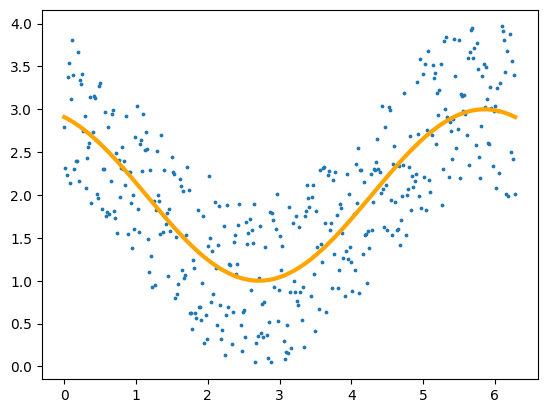

In [4]:
import math
import matplotlib.pyplot as plt
## Generate some noisy data
n = 400 # Length of the data
wl = 2 # Wavelength of underlying data
noise_level = 2 # Strength of noise

x = np.linspace(0,wl*math.pi,n)
data_clean = np.sin(x+2)+ noise_level
data = data_clean + (np.random.random(n)-0.5)*noise_level

plt.scatter(x, data, s=3)
plt.plot(x, data_clean, 'orange', linewidth=3)

In orange you can see the original function of the data, in blue the noisy data that you have to smooth.

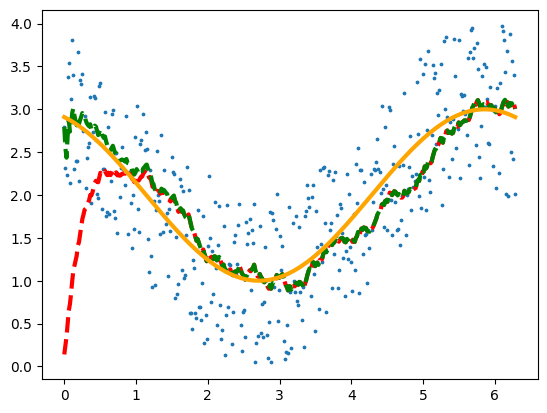

In [5]:
rho = 0.95 # Rho value for smoothing

s_prev = 0 # Initial value ewma value

# Empty arrays to hold the smoothed data
ewma, ewma_bias_corr = np.empty(0), np.empty(0)

for i, y in enumerate(data):
    t = i + 1  # time index (1-based)

    # EWMA update
    s_cur = rho * s_prev + (1 - rho) * y

    # Bias-corrected EWMA
    s_cur_bc = s_cur / (1 - rho**t)

    # Append new smoothed values
    ewma = np.append(ewma, s_cur)
    ewma_bias_corr = np.append(ewma_bias_corr, s_cur_bc)

    # Update previous
    s_prev = s_cur

plt.scatter(x, data, s=3) # Plot the noisy data in gray
plt.plot(x, ewma, 'r--', linewidth=3) # Plot the EWMA in red
plt.plot(x, ewma_bias_corr, 'g--', linewidth=3) # Plot the EWMA with bias correction in green
plt.plot(x, data_clean, 'orange', linewidth=3) # Plot the original data in orange

The final graphic clearly shows the effect of EWMA. Although the data is quite noisy, we can see that the EWMA is able to approximate the underlying function pretty well. Note the importance of the bias correction.


## A5.2 Momentum, RMSProp & Adam

Now that you have seen what an EWMA looks like in 1D we're ready to use it to build some optimizers for a 2D case and look at some nice visuals.

You'll get the opportunity to explore three different types of optimizers that should be familiar from the lectures: Momentum, RMSProp and Adam. There are multiple others optimizers available, but these three should give you a good intuition of what an optimizer does and a solid base to understand other optimizers.

Well use a quadratic function (inspired by [this]( https://xavierbourretsicotte.github.io/Intro_optimization.html) tutorial) as a toy example to show the effects of different optimizers. We'll use the derivative of that function to calculate our gradients.

NOTE: This is only a toy example and not a complete representation of stochastic gradient descent. Since we're using a function and it's derivative we **know** the exact distribution of our data. In a real world example we would not know the exact distribution of our data and would use batches of our training examples to approximate the gradient.

In the following exercises you will be asked to implement all three optimizers and see how they compare.

In the next cell we will define the two methods that define the quadratic function and it's derivative to calculate the gradients as well as two helper functions to help us visualize the function and the training.

Using the ```setup_figure``` function we can plot the surface and contours of the quadratic functions we defined. You can always rerun this cell to reset your plot.

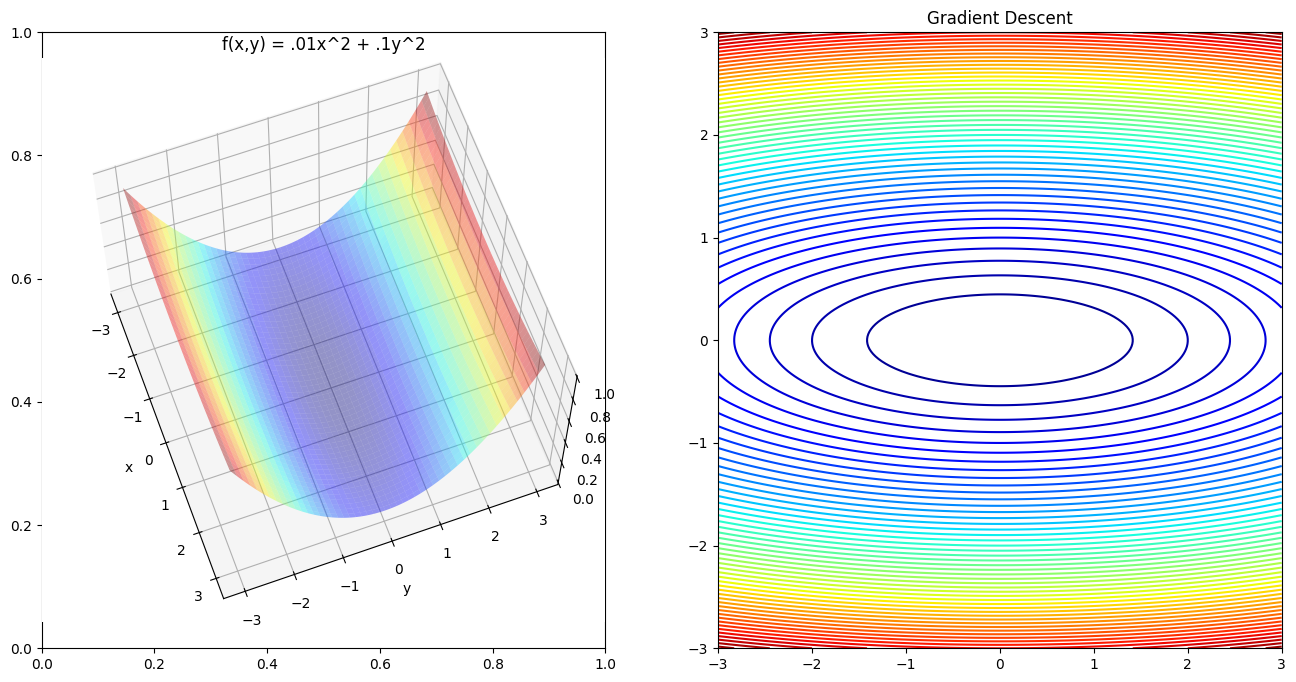

In [6]:
def f(x,y):
    '''A simple quadratic function'''
    return .01*x**2 + .1*y**2

def Grad_f(x,y):
    '''Gradients of function f'''
    g1 = 2*.01*x
    g2 = 2*.1*y
    return np.array([g1,g2])

%matplotlib inline

def setup_figure(f):
    '''Creates a Surface and a contour plot of the function f'''
    x = np.linspace(-3, 3, 250)
    y = np.linspace(-3, 3, 250)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

    # Surface plot
    ax1 = plt.subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Z, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
    ax1.set_title('f(x,y) = .01x^2 + .1y^2')

    ax1.view_init(65, 340)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    # Contour plot
    ax2 = plt.subplot(122)
    ax2.contour(X, Y, Z, 50, cmap='jet')
    ax2.set_title('Gradient Descent')

    return fig,(ax1,ax2)

def add_line(iter_x,iter_y,fig,ax1,ax2,color='r'):
    '''Adds lines to the provided figure'''

    # Angles needed for quiver plot
    anglesx = iter_x[1:] - iter_x[:-1]
    anglesy = iter_y[1:] - iter_y[:-1]

    ax1.plot(iter_x, iter_y, f(iter_x,iter_y), color=color, marker='*', alpha=.4)

    ax2.scatter(iter_x,iter_y,color = color, marker='*')
    ax2.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units='xy',
               angles='xy', scale=1, color=color, alpha=.3)
    return fig, (ax1, ax2)

# Get figure and axis and plot to show
fig, axs = setup_figure(f)

Next we define another helper function for our gradient descent. Only the first three arguments of the test_optimizer function are important to you, the rest you can ignore.

This function is written in a way that it accepts a Python function as the  ```optimizer``` argument. In the following exercises you will define those functions to implement the Momentum, RMSProp and Adam optimizer.

For the first iterations keep the learning rate and other optimizer parameters at their predefined values. Once you have implemented all optimizers feel free to explore how different parameter values influence different optimizers.

In [7]:
def test_optimizer(optimizer, rhos, learning_rate=0.00125,
                   starting_point=(-2,-2), nMax=10000, epsilon=0.0001,
                   Grad = Grad_f):
    """
    Tester function for optimization algorithms. Performs gradient descent using
    the provided Gradient until error < epsilon is reached.

    Args:
        optimizer: Optimization algorithm.
        rhos: Hyperparameters used in some optimization algorithms.
        learning_rate: Optimization step size.
        starting_point: Initialization point of optimization parameters.
        nMax: Maximum number of iterations to perform.
        epsilon: Stop optimization if error < epsilon.
        Grad: Gradient of quadratic function.
    """

    # Starting points
    x, y = starting_point

    # Initialization
    i = 0
    iter_x, iter_y, iter_count = np.empty(0), np.empty(0), np.empty(0)
    error = 10
    X = np.array([x,y])

    # Cache for previous values of optimizers
    prev_vals = np.zeros_like(rhos)

    # Looping as long as error is greater than epsilon
    while np.linalg.norm(error) > epsilon and i < nMax:
        i += 1
        iter_x = np.append(iter_x, x)
        iter_y = np.append(iter_y, y)
        iter_count = np.append(iter_count, i)

        X_prev = X

        # Perform optimization step
        X, prev_vals = optimizer(X, rhos, learning_rate, prev_vals, i)

        # Calculate error
        error = X - X_prev
        x,y = X[0], X[1]

    return iter_x, iter_y


The simplest form of an optimizer is SGD. It will always follow the gradient. Although this can lead to some good results, it requires some careful tuning of the learning rate to make sure the steps it takes are large enough to reach a minimum in appropriate time and not overshoot it's target.

The following cell shows how a gradient update with gradient descent is implemented.

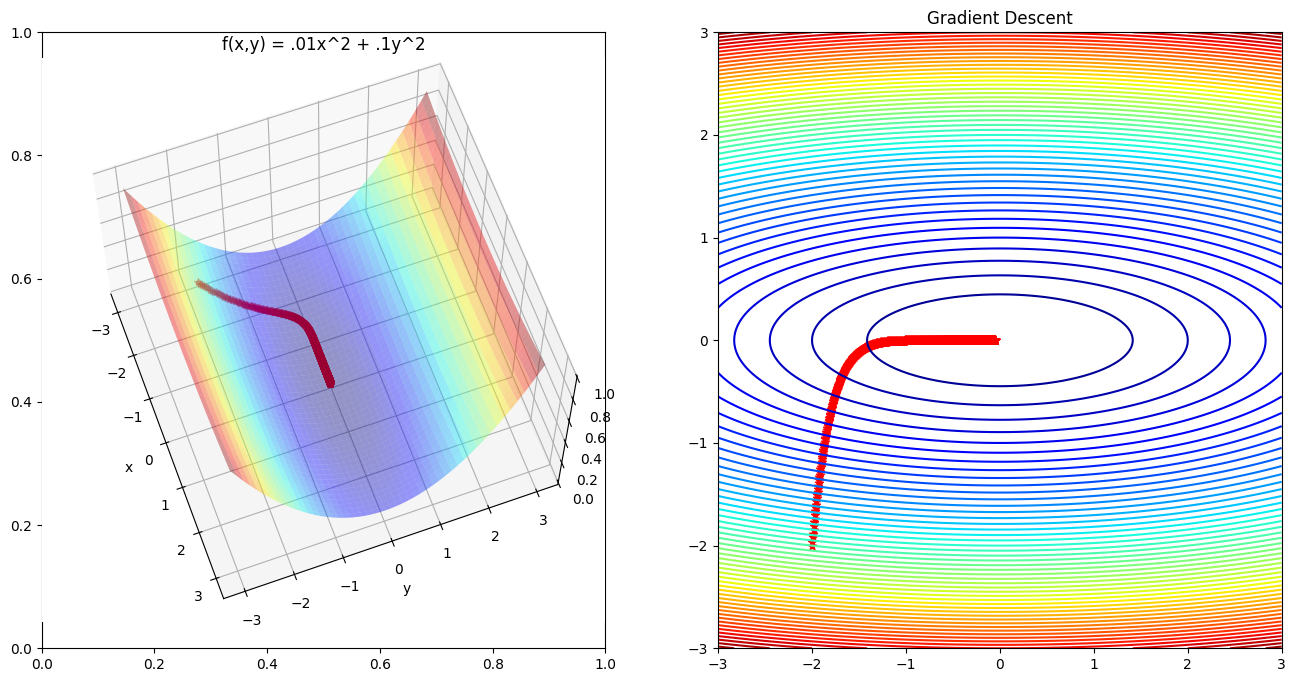

In [8]:
def vanilla_gd(X, rhos, learning_rate, prev_value, index, Grad=Grad_f):
    """
    Vanilla gradient descent optimization step.

    Args:
        X: Current value of objective function.
        rhos: Not used.
        learning_rate: Optimization step size.
        prev_value: Not used.
        index: Not used.
        Grad: Gradient of quadratic function.
    """
    gradient = Grad(*X)

    X = X - learning_rate * gradient

    return X, 0

# Optimization settings
lr = 0.1
rho = None # rho is not used in gradient descent

# Run optimization
x_gd, y_gd = test_optimizer(vanilla_gd, rho, lr)

# Plot optimization trajectory
add_line(x_gd, y_gd, fig, *axs, color='r')

# Show figure
fig

Momentum is simply EWMA applied to gradient descent. It helps smoothen the gradient updates by incorporating earlier gradient steps. This is especially handy in case the SGD is overshooting the minimum due to a too high learning rate.
In case of overshooting the gradient will point in (nearly opposite directions) after each update, by averaging over multiple gradients this will get cancelled out.

The formula for a gradient update with momentum is:

$$v_i=\rho v_{i-1}+(1-\rho)\nabla_{\theta}$$

$$\theta^{\prime}=\theta-\epsilon v_i$$

Implement the gradient update with momentum in the cell below.


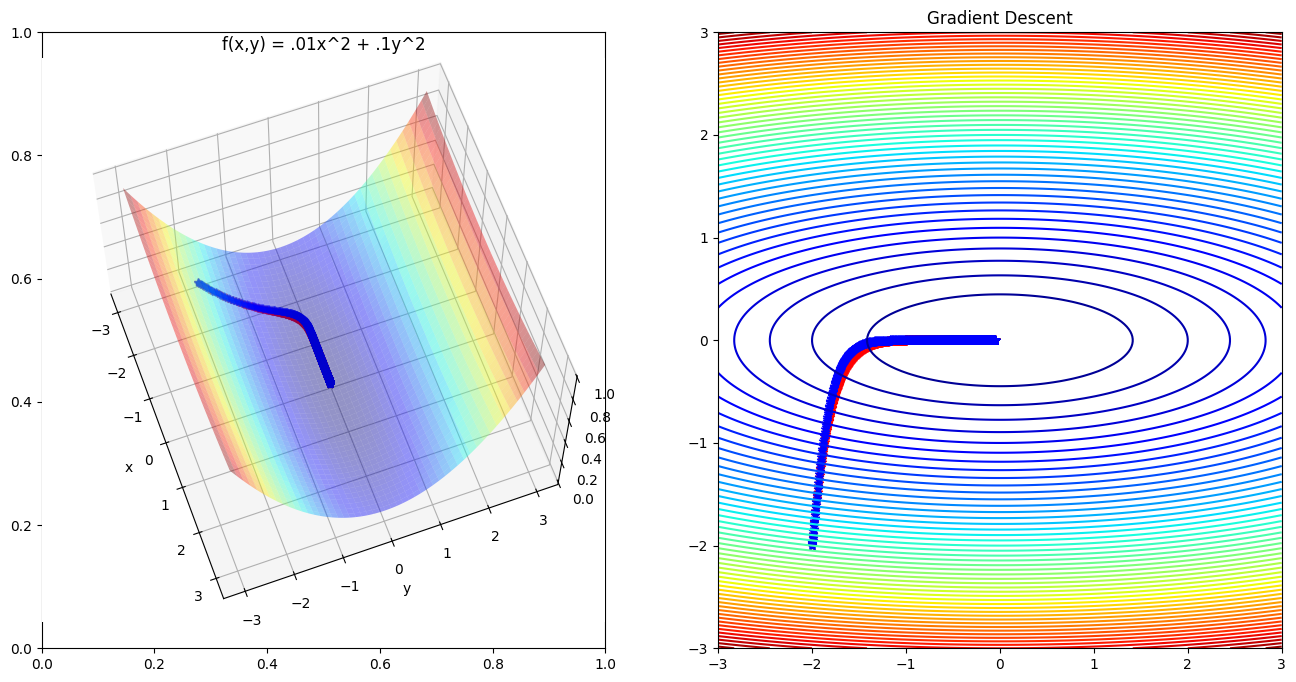

In [9]:
def momentum(X, rho, learning_rate, prev_value, index, Grad=Grad_f):
    """
    Gradient descent with momentum optimization step.

    Args:
        X: Current value of objective function.
        rhos: Optimization hyperparameter - see formula above.
        learning_rate: Optimization step size.
        prev_value: Momentum parameter from previous iteration.
        index: Not used.
        Grad: Gradient of quadratic function.
    """
    gradient = Grad(*X) # Gradient of current values
    v = 0               # Momentum parameter
    v_prev = prev_value # Momentum parameter from previous iteration

    v = rho * v_prev + (1-rho) * gradient
    X = X - learning_rate * v
    return X, v

# Optimization settings
lr = 0.1
rho = 0.9

# Run optimization
res_mom = test_optimizer(momentum, rho, lr)

# Plot optimization trajectory
add_line(*res_mom, fig, *axs, color='b')

# Show figure
fig

RMSProp also uses EWMA for previous versions of the gradient update. However, unlike momentum it does not use this average to update the gradient directly but to scale the learning rate of update. By doing this it is able to take larger steps towards the beginning of the learning process and smaller steps towards the end.

The formula for a gradient update with RMSProp is:

$$r_i=\rho r_{i-1}+(1-\rho)\nabla^2_{\theta}$$

$$\theta^{\prime}=\theta-\epsilon \frac{\nabla_\theta}{\sqrt{r_i+\delta}}$$

Implement the gradient update with RMSProp in the cell below.

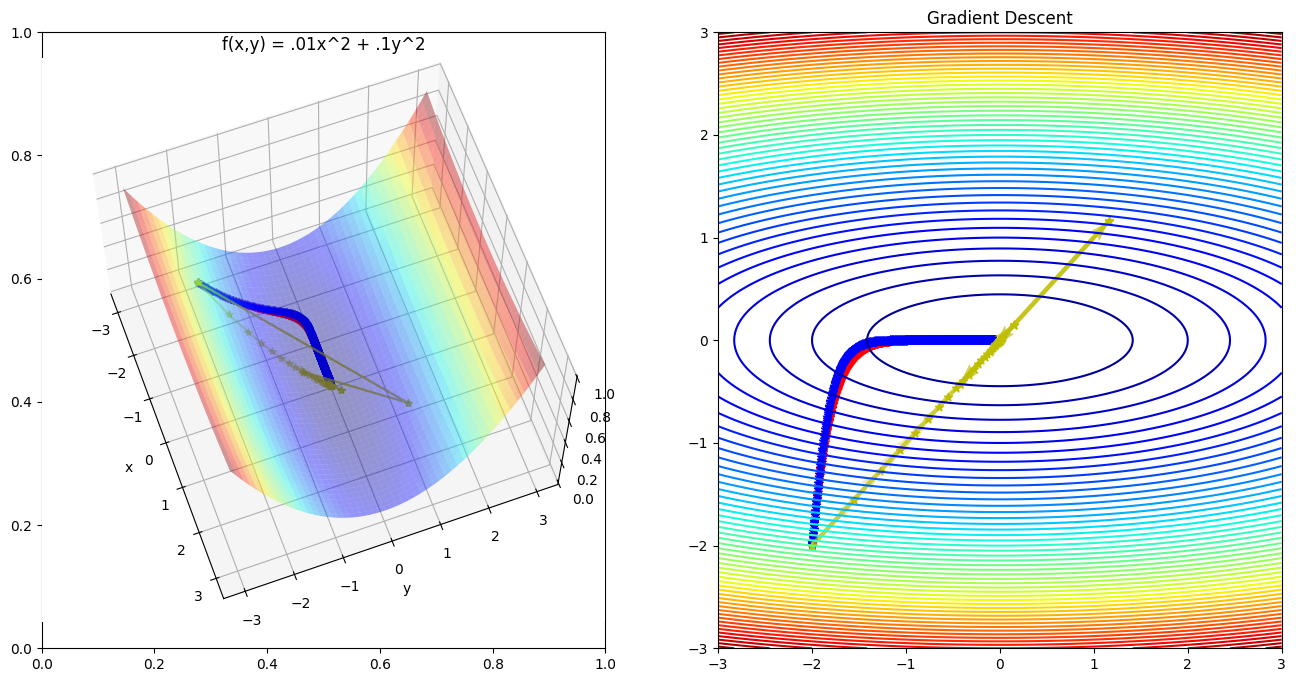

In [16]:
def RMSprop(X, rho, learning_rate, prev_value, index, Grad=Grad_f):
    eps = 1e-6  # slightly larger to avoid an enormous first step
    g = np.asarray(Grad(*X), dtype=float)

    # Ensure accumulator has same shape as g
    if np.isscalar(prev_value):
        r_prev = np.zeros_like(g, dtype=float)
    else:
        r_prev = np.asarray(prev_value, dtype=float)

    # Exponential moving average of squared grads (element-wise)
    r = rho * r_prev + (1.0 - rho) * (g ** 2)

    # Update (eps OUTSIDE sqrt; ∇^2 means elementwise square, not Hessian)
    X = np.asarray(X, dtype=float) - learning_rate * g / (np.sqrt(r) + eps)

    return X, r
# Optimization settings
lr = 0.1
rho = 0.95

# Run optimization
res_rmsprp = test_optimizer(RMSprop,rho,lr)

# Plot optimization trajectory
add_line(*res_rmsprp,fig,*axs,color='y')

# Show figure
fig

The idea behind the last optimizer, Adam, is simple. It combines both Momentum and RMSProp in a single optimizer.

The formula for a gradient update with Adam is:

$$v_i=\rho_1 v_{i-1}+(1-\rho_1)\nabla_{\theta}$$

$$\hat{v_i}=\frac{v_i}{1-\rho^i_1}$$

$$r_i=\rho_2 r_{i-1}+(1-\rho_2)\nabla^2_{\theta}$$

$$\hat{r_i}=\frac{r_i}{1-\rho^i_2}$$

$$\theta^{\prime}=\theta-\epsilon \frac{\hat{v_i}}{\sqrt{\hat{r_i}+\delta}}$$

Implement the gradient update with Adam in the cell below.

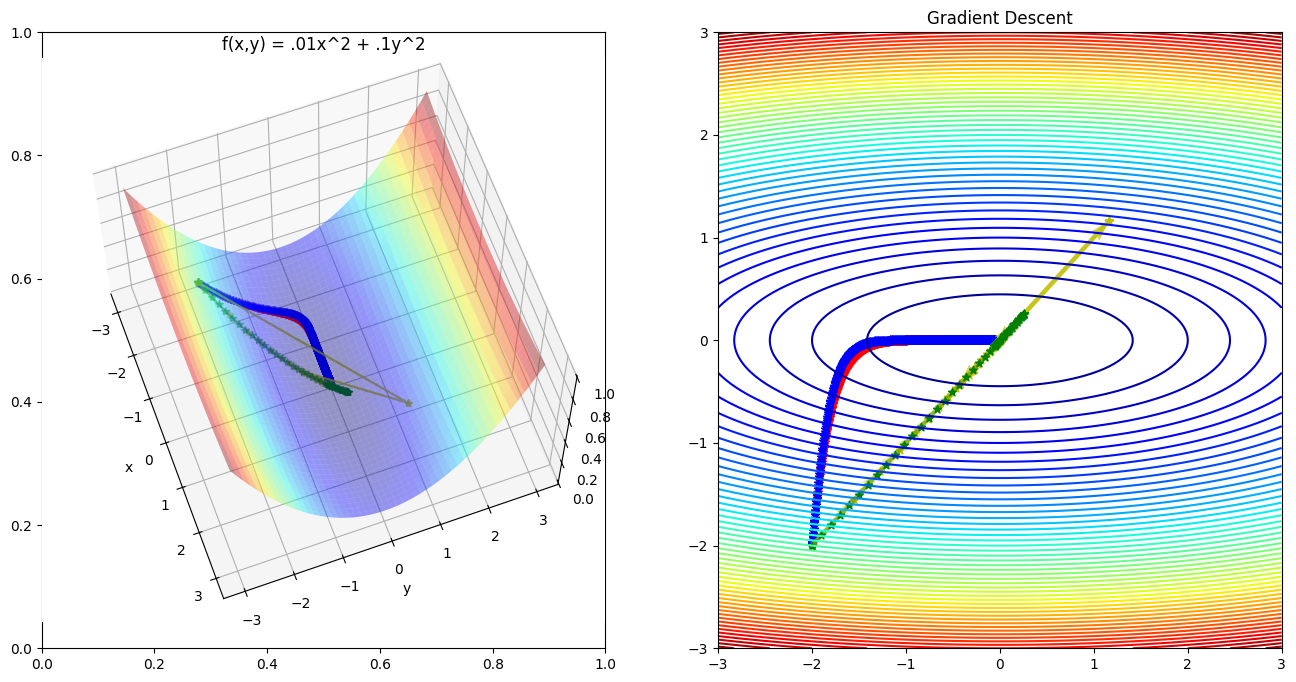

In [17]:
def adam(X, rhos, learning_rate, prev_values, index, Grad=Grad_f):
    eps = 1e-6

    rho_v, rho_r = rhos          # beta1, beta2
    v_prev, r_prev = prev_values

    # Gradient (ensure ndarray)
    g = np.asarray(Grad(*X), dtype=float)

    # Ensure previous states have correct shape
    v_prev = np.zeros_like(g) if np.isscalar(v_prev) else np.asarray(v_prev, dtype=float)
    r_prev = np.zeros_like(g) if np.isscalar(r_prev) else np.asarray(r_prev, dtype=float)

    # 1) Exponential moving averages
    v = rho_v * v_prev + (1.0 - rho_v) * g          # first moment
    r = rho_r * r_prev + (1.0 - rho_r) * (g ** 2)   # second moment

    # 2) Bias correction
    t = index
    v_bc = v / (1.0 - (rho_v ** t))
    r_bc = r / (1.0 - (rho_r ** t))

    # 3) Parameter update
    X_arr = np.asarray(X, dtype=float) - learning_rate * v_bc / (np.sqrt(r_bc) + eps)

    # Keep output type consistent with input
    X_out = tuple(X_arr) if isinstance(X, (tuple, list)) else X_arr
    return X_out, (v, r)

# Optimization settings
lr = 0.1
rhos = (0.9, 0.999)

# Run optimization
res_adam = test_optimizer(adam,rhos,lr)

# Plot optimization trajectory
add_line(*res_adam, fig, *axs, color='g')

# Show figure
fig

Now that you have implemented gradient descent with momentum, RMSprop and Adam you can start to play around with the optimizer hyperparameters.

****
**What effect does the learning rate have? </br> What is the effect of the rho parameters?**
****

## A5.3 Comparing optimizers in PyTorch

It is time to put SGD with momentum, RMSProp and Adam to the test. We will investigate how the optimizer choice influences the convergence speed and final performance on our already well known MNIST-1D classification task. You will use the training loop and model definition from the previous assignments - let us start by setting them up.

In [30]:
!pip install mnist1d
import mnist1d

# Set the batch size for training & testing
b_size = 100

# Load data
data = mnist1d.get_dataset(get_dataset_args())
# Convert 1D MNIST data to pytorch tensors
X_train = torch.tensor(data['x'], dtype=torch.float32)
y_train = torch.tensor(data['y'], dtype=torch.long)
X_test  = torch.tensor(data['x_test'], dtype=torch.float32)
y_test  = torch.tensor(data['y_test'], dtype=torch.long)

# ---------------------------
# Normalize using train stats
# ---------------------------
mu = X_train.mean(0, keepdim=True)
sd = X_train.std(0, keepdim=True).clamp_min(1e-6)  # prevent div by zero
X_train = (X_train - mu) / sd
X_test  = (X_test  - mu) / sd

# Create dataloaders
b_size = 100
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=b_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, y_test),  batch_size=b_size, shuffle=False)
##########################################
### Define training and test functions ###
##########################################

def train(train_loader, net, optimizer, criterion):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # iterate through batches
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return avg_loss/len(train_loader), 100 * correct / total

def test(test_loader, net, criterion):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        net: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # iterate through batches
        for data in test_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # keep track of loss and accuracy
            avg_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return avg_loss/len(test_loader), 100 * correct / total

####################
### Define model ###
####################

class FCNet(nn.Module):
    """
    Simple fully connected neural network with residual connections in PyTorch.
    Layers are defined in __init__ and forward pass implemented in forward.
    """

    def __init__(self):
        super(FCNet, self).__init__()

        self.fc1 = nn.Linear(40, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, 200)
        self.fc5 = nn.Linear(200, 200)
        self.fc6 = nn.Linear(200, 10)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = h + F.relu(self.fc2(h))
        h = h + F.relu(self.fc3(h))
        h = h + F.relu(self.fc4(h))
        h = h + F.relu(self.fc5(h))
        return self.fc6(h)

# Print network architecture using torchsummary
summary(FCNet(), (40,), device='cpu')

File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]           8,200
            Linear-2                  [-1, 200]          40,200
            Linear-3                  [-1, 200]          40,200
            Linear-4                  [-1, 200]          40,200
            Linear-5                  [-1, 200]          40,200
            Linear-6                   [-1, 10]           2,010
Total params: 171,010
Trainable params: 171,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.65
Estimated Total Size (MB): 0.66
----------------------------------------------------------------


In [32]:
import time, torch, numpy as np

torch.manual_seed(0)
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, a=np.sqrt(5))
        if m.bias is not None: torch.nn.init.zeros_(m.bias)

def make_model():
    net = FCNet()
    net.apply(reset_weights)
    return net

def run(optim_name, lr, epochs=5, momentum=0.9, betas=(0.9,0.999), eps=1e-8):
    net = make_model()
    criterion = torch.nn.CrossEntropyLoss()
    if optim_name=="sgd_mom":
        opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    elif optim_name=="rmsprop":
        opt = torch.optim.RMSprop(net.parameters(), lr=lr, alpha=0.99, eps=eps)
    elif optim_name=="adam":
        opt = torch.optim.Adam(net.parameters(), lr=lr, betas=betas, eps=eps)
    else:
        raise ValueError

    t0=time.time()
    reached90=None
    logs=[]
    for ep in range(1, epochs+1):
        tr_loss,tr_acc = train(train_loader, net, opt, criterion)
        te_loss,te_acc = test(test_loader, net, criterion)
        logs.append((ep,tr_loss,tr_acc,te_loss,te_acc,time.time()-t0))
        if reached90 is None and te_acc>=90.0:
            reached90=ep
    return {"optim":optim_name,"lr":lr,"logs":logs,"t_to_90ep":reached90}

# grid
configs = [
    ("sgd_mom",[0.1, 0.05, 0.02]),
    ("rmsprop",[0.01, 0.003, 0.001]),
    ("adam",   [0.003, 0.001, 0.0003]),
]

results=[]
for name, lrs in configs:
    for lr in lrs:
        torch.manual_seed(0)     # reproducible re-init+data order
        np.random.seed(0)
        results.append(run(name, lr, epochs=50))

# summarize
for r in results:
    best = max(r["logs"], key=lambda z: z[4])[4]
    first90 = r["t_to_90ep"]
    print(f"{r['optim']:8s} lr={r['lr']:7.4f} | best test acc ~{best:.1f}% | epochs to 90%: {first90}")

sgd_mom  lr= 0.1000 | best test acc ~72.7% | epochs to 90%: None
sgd_mom  lr= 0.0500 | best test acc ~72.8% | epochs to 90%: None
sgd_mom  lr= 0.0200 | best test acc ~71.3% | epochs to 90%: None
rmsprop  lr= 0.0100 | best test acc ~66.7% | epochs to 90%: None
rmsprop  lr= 0.0030 | best test acc ~69.8% | epochs to 90%: None
rmsprop  lr= 0.0010 | best test acc ~69.3% | epochs to 90%: None
adam     lr= 0.0030 | best test acc ~71.7% | epochs to 90%: None
adam     lr= 0.0010 | best test acc ~68.2% | epochs to 90%: None
adam     lr= 0.0003 | best test acc ~62.3% | epochs to 90%: None


This concludes assignment 4!